Import some standard (numpy, matplotlib, and deepcopy) modules and the python library for STiC:

In [1]:
import coupled_stic as sp
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from copy import deepcopy as cp

Define some functions to plot profiles, models and response functions:

In [2]:
def plot_profile(llp, t=0, y=0, x=0, s=0, kwargs=[], plkwargs={}):
    #
    #
    # Check inputs
    if (len(kwargs)!=len(llp)):
        ikwargs = [{},] * len(llp)
    else:
        ikwargs = cp(kwargs)
    #
    #
    ncols = len(llp[0].splitRegions())
    nrows = 1#np.ceil(npars/ncols).astype("i2")

    toadd_xlabel=1
    fg, ax = pl.subplots(ncols = ncols, nrows=nrows, sharey=1, **plkwargs)
    # Loop through profiles and plot kwargs
    labs = []
    for i,j in zip(llp, ikwargs):
        cnt=-1
        for k in i.splitRegions():
            cnt+=1
            ww = np.where(k.weights[:,s]<2)
            labs.append(ax.flat[cnt].plot(k.wav[ww[0]]-k.wav.mean(), k.dat[t,y,x,ww[0],s], **j))
            if (toadd_xlabel):
                ax.flat[cnt].set_xlabel(r"$\lambda-%.5f$" % (k.wav.mean(),))
        if (toadd_xlabel):
            toadd_xlabel=0
            
    #
    #
    # End plot:
    for i in ikwargs:
        if ("label" in i):
            lines_labels = [ax.flat[0].get_legend_handles_labels(),]
            lines, labels = [sum(i, []) for i in zip(*lines_labels)]
            fg.legend(lines, labels, loc="upper center", ncol=len(llp))
    fg.tight_layout()

In [3]:
def plot_model(llm, t=0, y=0, x=0, mpars=["temp", "vlos", "vturb", "Bln", "Bho", "azi"], kwargs=[], plkwargs={}, rfs=None):
    #
    #
    mnames = {"temp":"T", "vlos":r"v$_{\rm LOS}$", "vturb":r"v$_{\rm turb}$", "Bln":r"B$_{\parallel}$", "Bho":r"B$_{\perp}$", "azi":r"B$_{\phi}$"}
    munits = {"temp":"kK", "vlos":"km/s", "vturb":"km/s", "Bln":"G", "Bho":"G", "azi":"rd"}
    mfactors = {"temp":1.e-3, "vlos":1.e-5, "vturb":1.e-5, "Bln":1, "Bho":1, "azi":1}
    vmaxs = {"temp":12.5, "vlos":3, "vturb":5, "Bln":600, "Bho":1000, "azi":np.pi}
    vmins = {"temp":2.5, "vlos":-3, "vturb":0, "Bln":200, "Bho":0, "azi":0}

    dpar = {"temp":0, "vlos":1, "vturb":2, "Bln":3, "Bho":4, "azi":5}
    #
    # Check inputs
    if (len(kwargs)!=len(llm)):
        ikwargs = [{},] * len(llm)
    else:
        ikwargs = cp(kwargs)
    #
    plot_rf = False
    if (type(rfs)!=type(None)):
        assert type(rfs)==list
        assert len(rfs)==len(llm)
        plot_rf = True
    #
    npars = len(mpars)
    ncols = np.ceil(np.sqrt(npars)).astype("i2")
    nrows = np.ceil(npars/ncols).astype("i2")
    fg, ax = pl.subplots(ncols=ncols, nrows=nrows, sharex=True, **plkwargs)
    # Loop through model parameters and models and plot kwargs
    for lcp, lip in enumerate(mpars):
        cnt = -1
        for i,j in zip(llm, ikwargs):
            cnt+=1
            tmp = ax.flat[lcp].plot(i.ltau[t,y,x,:], getattr(i, lip)[t,y,x,:] * mfactors[lip], **j)
            if (plot_rf):
                if (type(rfs[cnt])!=type(None)):
                    #tadd = 1./np.abs(rfs[cnt].rf[t,y,x,dpar[lip],:,:,:]).sum((1,2))*np.sum(rfs[cnt].weights<1.e1)/600.
                    tadd = 1./np.abs(rfs[cnt].rf[t,y,x,dpar[lip],:,:,:]).sum((1,2))*10./600.

                    ax.flat[lcp].fill_between(i.ltau[t,y,x,:]
                                              , (getattr(i, lip)[t,y,x,:]-tadd) * mfactors[lip]
                                              , (getattr(i, lip)[t,y,x,:]+tadd) * mfactors[lip]
                                              , alpha=0.3, color=tmp[0].get_color())
    #
    #
    # End plot:
    for lcp, lip in enumerate(mpars):
        ax.flat[lcp].set_ylabel(r"%s [%s]" % (mnames[lip], munits[lip],))
        ax.flat[lcp].set_ylim(vmins[lip], vmaxs[lip])
    for i in ikwargs:
        if ("label" in i):
            pl.legend()
            break
    pl.tight_layout()

In [4]:
def plot_rf(llp, par, t=0, y=0, x=0, s=0, kwargs=[], plkwargs={}, yaxis=None):
    #
    #
    # Check inputs
    if (len(kwargs)!=len(llp)):
        ikwargs = [{},] * len(llp)
    else:
        ikwargs = cp(kwargs)
    #
    dpar = {"temp":0, "vlos":1, "vturb":2, "Bln":3, "Bho":4, "azi":5}
    #
    ncols = len(llp[0].splitRegions())
    nrows = len(llp)#np.ceil(npars/ncols).astype("i2")

    if (type(yaxis)==type(None)):
        ya = [0, llp[0].rf.shape[4]-1]
    else:
        ya = cp(yaxis)
    toadd_xlabel=1
    fg, ax = pl.subplots(ncols = ncols, nrows=nrows, sharey=1, **plkwargs)
    # Loop through profiles and plot kwargs
    for i,j in zip(llp, ikwargs):
        cnt=-1
        vmin, vmax = np.nanpercentile(i.rf[t,y,x,dpar[par],:,:,s].flatten(), [1,99])
        vval = np.max([np.abs([vmin, vmax])])
        vmin = -vval
        vmax = vval
        for k in i.splitRegions():
            cnt+=1
            xw = k.wav-k.wav.mean()
            ax.flat[cnt].imshow(k.rf[t,y,x,dpar[par],:,:,s], origin='lower', vmax=vmax, vmin=vmin, cmap="PuOr", interpolation="nearest", aspect="auto", extent=[xw[0],xw[-1],ya[0],ya[-1]])

            
            if (toadd_xlabel):
                ax.flat[cnt].set_xlabel(r"$\lambda-%.5f$" % (k.wav.mean(),))
        if (toadd_xlabel):
            toadd_xlabel=0
            
    #
    #
    # End plot:
    for i in ikwargs:
        if ("label" in i):
            fg.legend()
    fg.tight_layout()

There is a model atmosphere called "atmosout_bifrost_small.nc" that we will use to generate the synthetic observations and to which we will compare the model inferred.

In [5]:
m = sp.model("./atmosout_bifrost_small.nc")

model::read: atmos type -> depth-stratified
model::read: nx=46, ny=46, ndep=130, nt=1
model::setSize: nx = 46, ny = 46, ndep = 130, nt = 1


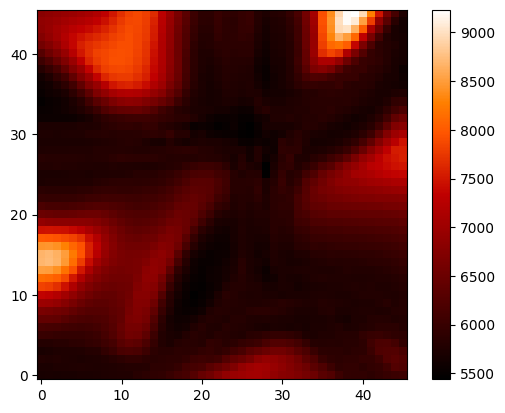

In [6]:
im = pl.imshow(m.temp[0,:,:,-19], origin="lower", cmap="gist_heat", interpolation="none")
cbar = pl.colorbar(im)

We will consider a very idealized situation for the "in-site" run so that we can have an example of a coupled inversion within the virtual-box:

Observations of two continuum points: at 4000 angstrom and 8000 angstrom

At 4000 angstrom we have significant noise level

At 8000 angstrom we have much better SNR but as we use the same optical system, the pixel size in this one is twice the former

In [7]:
waves = [4000., 8000.]

for i_wave, i_bin in zip(waves, [1,2]):
    p = sp.profile(nx=m.nx//i_bin, ny=m.ny//i_bin, nt=1, nw=1)
    prefix = ""
    if (i_bin>1):
        p.add_linear_transformation(4, [i_bin,i_bin,0,0,p.nx,p.ny])
        prefix = "bin"
    p.write("%s_profiles_%04i.nc" % (prefix,i_wave,))

profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
profile::write: saving data [_profiles_4000.nc]
profile::setsize: nx=23, ny=23, nw=1, ns=4, nt=1
profile::write: saving data [bin_profiles_8000.nc]


With these two profile classes, we can use STiC to generate our synthetic observations.

To do so, edit "input.cfg":

    Hint: mode, atmosphere_type, nodes_temp, depth_m, recompute_hydro,

    region = 4000.00000, 0.03913,  1, 2.34669e-05, none, none, profile_4000.nc
    region = 8000.00000, 0.03913,  1, 3.85647e-05, none, none, bin_profile_8000.nc

In [16]:
!ln -vfs input_coupled_synthesis.cfg input.cfg


'input.cfg' -> 'input_coupled_synthesis.cfg'


The following takes ~ 5 minutes.

In [17]:
!mpirun -n 3 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::

We load now the synthetic spectra and display it (taking into account that the continuum point at 8000 angstrom has twice the pixel size):

profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs' 'psf']
profile::read: [profiles][wav][weights][psf][lts][ltargs]
profile::setsize: nx=23, ny=23, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs']
profile::read: [profiles][wav][weights][lts][ltargs]


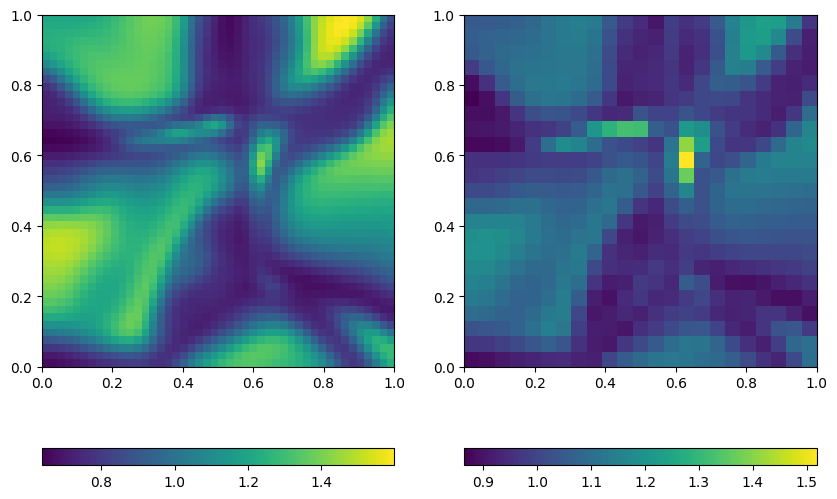

In [8]:
p4 = sp.profile("./out_profiles_4000.nc")
p8 = sp.profile("./out_bin_profiles_8000.nc")

fg, ax = pl.subplots(ncols=2, figsize=(10,7))
ims = []
cbars = []
for it, iax in zip([p4,p8], ax.flat):
    ims.append(iax.imshow(it.dat[0,:,:,0,0], origin='lower', interpolation='nearest', extent=[0,1,0,1]))
    cbars.append(pl.colorbar(ims[-1], ax=iax, orientation='horizontal'))


We use these synthetic data to add noise and use them for a coupled inversion:

In [9]:
# Add some noise:
snrs = [6, 600.]
rng = np.random.default_rng(seed=12345)
names = ["obs_profiles_4000.nc", "obs_bin_profiles_8000.nc"]

for i_p, i_name, i_snr in zip([p4, p8], names, snrs):
    nobs = cp(i_p)
    nobs.dat += rng.normal(size=nobs.dat.size).reshape(*nobs.dat.shape) / i_snr
    nobs.weights[:,1:] = 1.e32
    nobs.weights[:,0] = 1. / i_snr
    nobs.write(i_name)

profile::write: saving data [obs_profiles_4000.nc]
profile::write: saving data [obs_bin_profiles_8000.nc]


profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]
profile::setsize: nx=23, ny=23, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]


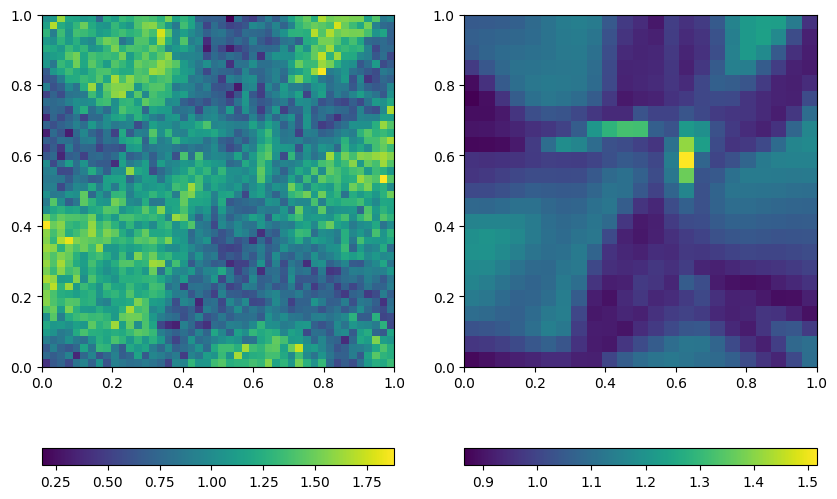

In [10]:
fg, ax = pl.subplots(ncols=2, figsize=(10,7))
ims = []
cbars = []
for it, iax in zip(names, ax.flat):
    p = sp.profile(it)
    ims.append(iax.imshow(p.dat[0,:,:,0,0], origin='lower', interpolation='nearest', extent=[0,1,0,1]))
    cbars.append(pl.colorbar(ims[-1], ax=iax, orientation='horizontal'))

In [11]:
gm = sp.get_init_model(nx=p4.nx, ny=p4.ny, nt=p4.nt, vmax=0.3, vmin=-0.7, vstp=0.2, axis="ltau")
gm.pgas = gm.pgas * 0. + 335200
gm.write("modelin.nc")

model::setSize: nx = 46, ny = 46, ndep = 6, nt = 1
model::write: modelin.nc -> nx=46, ny=46, ndep=6, nt=1


In [12]:
!ln -vfs input_coupled_inversion.cfg input.cfg

'input.cfg' -> 'input_coupled_inversion.cfg'


It takes ~ 30 minutes to run the following piece of code:

In [13]:
!mpirun -n 3 ./STiC.x


   SSSSSSSSSSSSSSS TTTTTTTTTTTTTTTTTTTTTTT  iiii         CCCCCCCCCCCCC
 SS:::::::::::::::ST:::::::::::::::::::::T i::::i     CCC::::::::::::C
S:::::SSSSSS::::::ST:::::::::::::::::::::T  iiii    CC:::::::::::::::C
S:::::S     SSSSSSST:::::TT:::::::TT:::::T         C:::::CCCCCCCC::::C
S:::::S            TTTTTT  T:::::T  TTTTTTiiiiiii C:::::C       CCCCCC
S:::::S                    T:::::T        i:::::iC:::::C              
 S::::SSSS                 T:::::T         i::::iC:::::C              
  SS::::::SSSSS            T:::::T         i::::iC:::::C              
    SSS::::::::SS          T:::::T         i::::iC:::::C              
       SSSSSS::::S         T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::iC:::::C              
            S:::::S        T:::::T         i::::i C:::::C       CCCCCC
SSSSSSS     S:::::S      TT:::::::TT      i::::::i C:::::CCCCCCCC::::C
S::::::SSSSSS:::::S      T:::::::::T      i::::::i  CC:::::::::::::::C
S::::


This time, we have two different sets of observations, the undegraded synthetic profiles (which in this example are fairly similar or even equal to the degraded ones) and the degraded ones that are the actual profiles that are compared during the inversion.

    Undegraded data: stk_inv_00.nc
    Degraded data:
        out_obs_profiles_4000.nc -> Strictly equal to the undegraded ones in this example
        out_obs_bin_profiles_8000.nc -> They are binned (2x2) as compared to the original ones


In [14]:
inv_und_prof = sp.profile("./stk_inv_00.nc")
inv_p4 = sp.profile("./out_obs_profiles_4000.nc")
inv_p8 = sp.profile("./out_obs_bin_profiles_8000.nc")


profile::setsize: nx=46, ny=46, nw=2, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs' 'psf']
profile::read: [profiles][wav][weights][psf][lts][ltargs]
profile::setsize: nx=23, ny=23, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs']
profile::read: [profiles][wav][weights][lts][ltargs]


Undeground truth to compare the undegraded data to:

    stk_bifrost_small.nc

Degraded "Observations" to compare degraded data to:

    obs_profiles_4000.nc
    obs_bin_profiles_8000.nc

In [15]:
obs_und_prof = sp.profile("./stk_bifrost_small.nc")
obs_p4 = sp.profile("./obs_profiles_4000.nc")
obs_p8 = sp.profile("./obs_bin_profiles_8000.nc")


profile::setsize: nx=46, ny=46, nw=2, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=46, ny=46, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]
profile::setsize: nx=23, ny=23, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]


Use whatever comparison you might think of to convince yourself about the inferred result...

If the observed features are properly/satisfactorily fitted, let us see how similar is the inferred model as compared to the one we used to generate the "observations":

In [16]:
om = sp.model("./atm_bifrost_small.nc")
im = sp.model("atm_inv_00.nc")

model::read: atmos type -> depth-stratified
model::read: nx=46, ny=46, ndep=130, nt=1
model::setSize: nx = 46, ny = 46, ndep = 130, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=46, ny=46, ndep=6, nt=1
model::setSize: nx = 46, ny = 46, ndep = 6, nt = 1


As a final aside, I include the result of a larger example (still two continuum points) taking into account the effect of the PSF of each spectral window:

In [17]:
inv_und_prof = sp.profile("./full_stk_inv_00.nc")
inv_p4 = sp.profile("./out_obs_full_profiles_4000.nc")
inv_p8 = sp.profile("./out_obs_bin_full_profiles_8000.nc")


profile::setsize: nx=504, ny=504, nw=2, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=504, ny=504, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs' 'psf']
profile::read: [profiles][wav][weights][psf][lts][ltargs]
profile::setsize: nx=252, ny=252, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'lts' 'ltargs' 'psf']
profile::read: [profiles][wav][weights][psf][lts][ltargs]


In [18]:
obs_und_prof = sp.profile("./stk_bifrost_full.nc")
obs_p4 = sp.profile("./obs_full_profiles_4000.nc")
obs_p8 = sp.profile("./obs_bin_full_profiles_8000.nc")


profile::setsize: nx=504, ny=504, nw=6, ns=4, nt=1
['profiles' 'wav' 'weights']
profile::read: [profiles][wav][weights]
profile::setsize: nx=504, ny=504, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]
profile::setsize: nx=252, ny=252, nw=1, ns=4, nt=1
['profiles' 'wav' 'weights' 'pixel_weights' 'psf' 'lts' 'ltargs' 'ds']
profile::read: [profiles][wav][weights][pixel_weights][psf][lts][ltargs][ds]


Are the inversions good enough?

...


If so, let us compare the inferred model with the underground truth:

In [19]:
om = sp.model("./red_atm_bifrost_full.nc") # Model resampled to inverted lg tau
im = sp.model("full_atm_inv_00.nc")

model::read: atmos type -> depth-stratified
model::read: nx=504, ny=504, ndep=8, nt=1
model::setSize: nx = 504, ny = 504, ndep = 8, nt = 1
model::read: atmos type -> depth-stratified
model::read: nx=504, ny=504, ndep=8, nt=1
model::setSize: nx = 504, ny = 504, ndep = 8, nt = 1



Message to take home:

    The results of the inference depend on the model one choses to explain the observations and the posterior analysis has to be done with that in mind!

    In the previous one, "the model" includes not only number of nodes, weights, regularization, and physics included in the forward modeling but also the instrument employed for the observations!

    The same goes for any spatial degradation acting on the data. This is critical when using data from different spectral regions and/or instruments and/or telescopes.
